In [1]:
import os
from tempfile import tempdir
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms
import corems.lc_icpms_ftms.calc.lc_icrms_helpers as lcmsfns

import importlib

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

drive_dir = '/Users/christiandewey/Library/CloudStorage/GoogleDrive-christian.w.dewey@gmail.com/My Drive/manuscripts/2023_Dewey-Boiteau-etal_mz-windowing/' 
svdir = drive_dir + 'figures/'

In [9]:
class Assignments:
    ''' 18 Feb 23
        Author: Christian Dewey
        
        intended for m/z windowing project
        works for 200 and 1000 m/z windows (not 100 m/z)
    '''
    def __init__(self, processed_assignments, mzrange, dataset_name):
        
        self._data_df = processed_assignments

        self.mzrange = mzrange

        self.dataset_name = dataset_name
        
        self.subsetByWindow()

        self.subsetAssignedUnique()

        self.combine()

        self.determineOverlap()


    def subsetByWindow(self):
        # create subsets of assignments based m/z window
        list200mz = []
        listfullzmz = [] 
        for mzwindow in self._data_df['Window Size (m/z)'].unique():

            r_df = self._data_df[self._data_df['Window Size (m/z)'] == mzwindow]

            if (mzwindow =='200'):
                list200mz.append(r_df) 

            elif (mzwindow =='1000'):
                listfullzmz.append(r_df) 

        self.mz200 = pd.concat(list200mz,ignore_index=True)
        self.mzfull = pd.concat(listfullzmz,ignore_index=True)

        self.mzfull_range = self.mzfull[(self.mzfull['m/z']>=self.mzrange[0])]
        self.mzfull_range = self.mzfull_range[(self.mzfull_range['m/z']<=self.mzrange[1])]

    def subsetAssignedUnique(self):
        # create subsets of assigned features and unique features 

        self.assigned_200mz = self.mz200[~self.mz200['Molecular Formula'].isnull()]
        self.assigned_fullmz = self.mzfull[~self.mzfull['Molecular Formula'].isnull()]

        self.unique_200mz = lcmsfns.getUniqueFeatures(self.assigned_200mz)
        self.unique_fullmz = lcmsfns.getUniqueFeatures(self.assigned_fullmz)

        print('\n200 m/z window (narrow):')
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mz200)[0],  np.shape(self.assigned_200mz)[0], (np.shape(self.assigned_200mz)[0] / np.shape(self.mz200)[0] * 100), np.shape(self.unique_200mz)[0]))
        print('\n200-1200 m/z window (full):')
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mzfull)[0],np.shape(self.assigned_fullmz)[0],  (np.shape(self.assigned_fullmz)[0] / np.shape(self.mzfull)[0] * 100),np.shape(self.unique_fullmz)[0]))

        self.assigned_fullmz_range = self.assigned_fullmz[(self.assigned_fullmz['m/z']>=self.mzrange[0])]
        self.assigned_fullmz_range = self.assigned_fullmz_range[(self.assigned_fullmz_range['m/z']<=self.mzrange[1])]
        self.unique_fullmz_range = lcmsfns.getUniqueFeatures(self.assigned_fullmz_range)

        print('\n200-1200 m/z window, between %s-%s m/z:' %(self.mzrange[0],self.mzrange[1]))
        print('%s features total\n%s assigned (%.1f%%)\n%s unique' %(np.shape(self.mzfull_range)[0],np.shape(self.assigned_fullmz_range)[0],  np.shape(self.assigned_fullmz_range)[0] / np.shape(self.mzfull_range)[0] * 100, len(self.unique_fullmz_range)))

    def combine(self):
        # get combo unique 
        self.combo_assigned = pd.concat([self.assigned_200mz, self.assigned_fullmz_range], ignore_index=True)
        self.combo_unique = lcmsfns.getUniqueFeatures(self.combo_assigned)
        self.combo_bs = pd.concat([lcmsfns.blankSubtract(self.unique_fullmz_range, blnkthresh = 0.6), 
            lcmsfns.blankSubtract(self.unique_200mz, blnkthresh = 0.6)], ignore_index=True)
        # combo without blank subtraction or removal of duplicate peaks
        mzfull_range = self.mzfull[(self.mzfull['Calibrated m/z']>=self.mzrange[0]) & (self.mzfull['Calibrated m/z']<=self.mzrange[1])]
        self.combo_all = pd.concat([self.mz200, mzfull_range], ignore_index=True)

        print('\n%s features total' %len(self.combo_all))
        print('%s assigned features' %len(self.combo_assigned))
        print('%s unique features' %len(self.combo_unique))
        print('%s unique features after blank subtraction' %len(self.combo_bs))
   

    def determineOverlap(self):

        dd = lcmsfns.blankSubtract(self.combo_unique)

        self.fullscan =  dd[dd['Window Size (m/z)'] == '1000']
        self.narrowscan = dd[dd['Window Size (m/z)'] == '200']

        self.features_in_narrow_only = dd[(dd['Molecular Formula'].isin(self.narrowscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(self.fullscan['Molecular Formula']))]
        self.features_in_full_only = dd[(dd['Molecular Formula'].isin(self.fullscan['Molecular Formula'])) & (~dd['Molecular Formula'].isin(self.narrowscan['Molecular Formula']))]

        self.features_in_both = dd[ (dd['Molecular Formula'].isin(self.narrowscan['Molecular Formula'])) & (dd['Molecular Formula'].isin(self.fullscan['Molecular Formula']))]
        self.features_not_in_full = dd[(~dd['Molecular Formula'].isin(self.fullscan['Molecular Formula']))]

        self.features_in_narrow_only['FeatureIn'] = '200'
        self.features_in_full_only['FeatureIn'] ='1000'
        self.features_in_both['FeatureIn'] = '200,1000'

        print('\n%s MFs in narrow window only' %len(self.features_in_narrow_only))
        print('%s MFs in full window only' %len(self.features_in_full_only))
        print('%s MFs in both windows' %len(self.features_in_both))
        print('%s MFs not in full window (should be same as MFs in narrow window)' %len(self.features_not_in_full))


In [209]:
## GENERAL PLOTTING FUNCS
def vanKrevelen(df,ax,hcol,col,leg=False):
    pal = sns.set_palette(sns.color_palette('mako'), n_colors=len(df[hcol].unique()))
    if leg is False:
        if len(df['Peak Height'] > 0):
            ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100),palette = pal, alpha = 0.5, legend=False) 
            ax.set_ylim(0.,3.)
            ax.set_xlim(0.,1.5)
    else:
        if len(df['Peak Height'] > 0):
            ax = sns.scatterplot(data=df,x='O/C',y='H/C',size = (df['Peak Height']/max(df['Peak Height'])),hue = hcol,ax = ax,sizes=(20, 100), palette = pal, alpha = 0.5) 
            ax.set_ylim(0.,3.)
            ax.set_xlim(0.,1.5)

def panelLabel(ax,lbl):
    ax.text(-.15, 1.1,lbl,
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes, fontweight='bold', fontsize = 10)

In [189]:
## FLUORINE van Krevelen panels

def make_F_VKpanels(assignments):
    time = 10
    time2 = 16
    snthresh = 5
    snthresh_low = 0
    el = 'F'

    
    fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

    features_in_all = assignments.features_in_both 
    features_in_all = features_in_all[(features_in_all['F']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    features_in_all = features_in_all[(features_in_all['m/z Error (ppm)']<0.1) & (features_in_all['m/z Error (ppm)']>-0.1)]
    
    df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax,el,'C0')
    ax.set_title('<%s min.' %time, size = 10)

    df = features_in_all[(features_in_all['Time']<time2 ) & (features_in_all['Time']>time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax2,el,'C0')
    ax2.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = features_in_all[(features_in_all['Time']>time2 ) & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax3,el,'C0')
    ax3.set_title('>%s min.' %time2, size = 10)


    dfm = assignments.features_in_narrow_only
    dfm = dfm[(dfm['F']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    dfm = dfm[(dfm['m/z Error (ppm)']<0.1) & (dfm['m/z Error (ppm)']>-0.1)]

    df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax4,el,'C1')
    ax4.set_title('<%s min.' %time, size = 10)

    df = dfm[(dfm['Time']>time) & (dfm['Time']<time2)& (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax5,el,'C1')
    ax5.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax6,el,'C1',leg=True)
    ax6.set_title('>%s min.' %time2, size = 10)
    h, l = ax6.get_legend_handles_labels()
    legend = ax6.legend()
    legend.remove()

    nEl = len(dfm[el].unique())+1
    L = fig.legend(h[1:nEl],l[1:nEl],title = 'F atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))


    plt.setp(L.get_title(),fontsize=10)

    axs = [ax, ax2, ax3, ax4, ax5, ax6]
    lbls = ['a','c','e','b','d','f']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)

    fig.tight_layout()
    fig.text(0.3, 1.0,'Narrow & Full',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)

    fig.text(0.78, 1.0,'Narrow Only',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)


    sns.despine()
    #plt.show()
    nm = 'vanKrevelen_F_SN-0to5_' + assignments.dataset_name
    plt.savefig(svdir+nm+'.pdf', bbox_inches = 'tight')

In [175]:
## IODINE van Krevelen panels

def make_I_VKpanels(assignments):
    time = 10
    time2 = 16
    snthresh = 5
    snthresh_low = 0
    el = 'I'

    
    fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

    features_in_all = assignments.features_in_both 
    features_in_all = features_in_all[(features_in_all['I']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    features_in_all = features_in_all[(features_in_all['m/z Error (ppm)']<0.1) & (features_in_all['m/z Error (ppm)']>-0.1)]
    
    df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax,el,'C0')
    ax.set_title('<%s min.' %time, size = 10)

    df = features_in_all[(features_in_all['Time']<time2 ) & (features_in_all['Time']>time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax2,el,'C0')
    ax2.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = features_in_all[(features_in_all['Time']>time2 ) & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax3,el,'C0')
    ax3.set_title('>%s min.' %time2, size = 10)


    dfm = assignments.features_in_narrow_only
    dfm = dfm[(dfm['I']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    dfm = dfm[(dfm['m/z Error (ppm)']<0.1) & (dfm['m/z Error (ppm)']>-0.1)]

    df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax4,el,'C1')
    ax4.set_title('<%s min.' %time, size = 10)

    df = dfm[(dfm['Time']>time) & (dfm['Time']<time2)& (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax5,el,'C1')
    ax5.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax6,el,'C1',leg=True)
    ax6.set_title('>%s min.' %time2, size = 10)
    h, l = ax6.get_legend_handles_labels()
    legend = ax6.legend()
    legend.remove()

    nEl = len(dfm[el].unique())+1
    L = fig.legend(h[1:nEl],l[1:nEl],title = 'I atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))


    plt.setp(L.get_title(),fontsize=10)

    axs = [ax, ax2, ax3, ax4, ax5, ax6]
    lbls = ['a','c','e','b','d','f']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)

    fig.tight_layout()
    fig.text(0.3, 1.0,'Narrow & Full',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)

    fig.text(0.78, 1.0,'Narrow Only',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)


    sns.despine()
    #plt.show()
    nm = 'vanKrevelen_I_SN-0to5_' + assignments.dataset_name
    plt.savefig(svdir+nm+'.pdf', bbox_inches = 'tight')

In [171]:
## SULFUR van Krevelen panels

def make_S_VKpanels(assignments):
    time = 10
    time2 = 16
    snthresh = 5
    snthresh_low = 0
    el = 'S'

    
    fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

    features_in_all = assignments.features_in_both 
    features_in_all = features_in_all[(features_in_all['S']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    features_in_all = features_in_all[(features_in_all['m/z Error (ppm)']<0.1) & (features_in_all['m/z Error (ppm)']>-0.1)]
    
    df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax,el,'C0')
    ax.set_title('<%s min.' %time, size = 10)

    df = features_in_all[(features_in_all['Time']<time2 ) & (features_in_all['Time']>time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax2,el,'C0')
    ax2.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = features_in_all[(features_in_all['Time']>time2 ) & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax3,el,'C0')
    ax3.set_title('>%s min.' %time2, size = 10)


    dfm = assignments.features_in_narrow_only
    dfm = dfm[(dfm['S']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    dfm = dfm[(dfm['m/z Error (ppm)']<0.1) & (dfm['m/z Error (ppm)']>-0.1)]

    df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax4,el,'C1')
    ax4.set_title('<%s min.' %time, size = 10)

    df = dfm[(dfm['Time']>time) & (dfm['Time']<time2)& (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax5,el,'C1')
    ax5.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax6,el,'C1',leg=True)
    ax6.set_title('>%s min.' %time2, size = 10)
    h, l = ax6.get_legend_handles_labels()
    legend = ax6.legend()
    legend.remove()

    nEl = len(dfm[el].unique())+1
    L = fig.legend(h[1:nEl],l[1:nEl],title = 'S atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))


    plt.setp(L.get_title(),fontsize=10)

    axs = [ax, ax2, ax3, ax4, ax5, ax6]
    lbls = ['a','c','e','b','d','f']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)

    fig.tight_layout()
    fig.text(0.3, 1.0,'Narrow & Full',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)

    fig.text(0.78, 1.0,'Narrow Only',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)


    sns.despine()
    #plt.show()
    nm = 'vanKrevelen_S_SN-0to5_' + assignments.dataset_name
    plt.savefig(svdir+nm+'.pdf', bbox_inches = 'tight')

In [167]:
## COPPER van Krevelen panels

def make_Cu_VKpanels(assignments):
    time = 10
    time2 = 16
    snthresh = 5
    snthresh_low = 0
    el = 'N'

    
    fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

    features_in_all = assignments.features_in_both 
    features_in_all = features_in_all[(features_in_all['Cu']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    features_in_all = features_in_all[(features_in_all['m/z Error (ppm)']<0.1) & (features_in_all['m/z Error (ppm)']>-0.1)]

    
    df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax,el,'C0')
    ax.set_title('<%s min.' %time, size = 10)

    df = features_in_all[(features_in_all['Time']<time2 ) & (features_in_all['Time']>time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax2,el,'C0')
    ax2.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = features_in_all[(features_in_all['Time']>time2 ) & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax3,el,'C0')
    ax3.set_title('>%s min.' %time2, size = 10)


    dfm = assignments.features_in_narrow_only
    dfm = dfm[(dfm['Cu']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    dfm = dfm[(dfm['m/z Error (ppm)']<0.1) & (dfm['m/z Error (ppm)']>-0.1)]

    df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax4,el,'C1')
    ax4.set_title('<%s min.' %time, size = 10)

    df = dfm[(dfm['Time']>time) & (dfm['Time']<time2)& (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax5,el,'C1')
    ax5.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax6,el,'C1',leg=True)
    ax6.set_title('>%s min.' %time2, size = 10)
    h, l = ax6.get_legend_handles_labels()
    legend = ax6.legend()
    legend.remove()

    nEl = len(dfm[el].unique())
    L = fig.legend(h[1:nEl+1],l[1:nEl+1],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i)))

    plt.setp(L.get_title(),fontsize=10)

    axs = [ax, ax2, ax3, ax4, ax5, ax6]
    lbls = ['a','c','e','b','d','f']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)

    fig.tight_layout()
    fig.text(0.3, 1.0,'Narrow & Full',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)

    fig.text(0.78, 1.0,'Narrow Only',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)


    sns.despine()
    #plt.show()
    nm = 'vanKrevelen_Cu_N_SN-0to5_' + assignments.dataset_name
    plt.savefig(svdir+nm+'.pdf', bbox_inches = 'tight')

In [161]:
## NITROGEN van Krevelen panels

def make_N_VKpanels(assignments):
    time = 10
    time2 = 16
    snthresh = 5
    snthresh_low = 0
    el = 'N'

    
    fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

    features_in_all = assignments.features_in_both 
    features_in_all = features_in_all[(features_in_all['N']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    features_in_all = features_in_all[(features_in_all['m/z Error (ppm)']<0.1) & (features_in_all['m/z Error (ppm)']>-0.1)]
    
    df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax,el,'C0')
    ax.set_title('<%s min.' %time, size = 10)

    df = features_in_all[(features_in_all['Time']<time2 ) & (features_in_all['Time']>time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax2,el,'C0')
    ax2.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = features_in_all[(features_in_all['Time']>time2 ) & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
    vanKrevelen(df,ax3,el,'C0')
    ax3.set_title('>%s min.' %time2, size = 10)


    dfm = assignments.features_in_narrow_only
    dfm = dfm[(dfm['N']>0)] # & (features_in_all['S']<3) & (features_in_all['P']<1) & (features_in_all['N']<4)]
    dfm = dfm[(dfm['m/z Error (ppm)']<0.1) & (dfm['m/z Error (ppm)']>-0.1)]


    
    df = dfm[(dfm['Time']>time) & (dfm['Time']<time2)& (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax5,el,'C1')
    ax5.set_title('Between %s and <%s min.' %(time,time2), size = 10)

    df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax6,el,'C1')
    ax6.set_title('>%s min.' %time2, size = 10)
    
    df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
    vanKrevelen(df,ax4,el,'C1',leg=True)
    ax4.set_title('<%s min.' %time, size = 10)
    h, l = ax4.get_legend_handles_labels()
    legend = ax4.legend()
    legend.remove()

    nEl = len(dfm[el].unique())
    
    L = fig.legend(h[1:nEl+1],l[1:nEl+1],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))



    plt.setp(L.get_title(),fontsize=10)

    axs = [ax, ax2, ax3, ax4, ax5, ax6]
    lbls = ['a','c','e','b','d','f']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)

    fig.tight_layout()
    fig.text(0.3, 1.0,'Narrow & Full',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)

    fig.text(0.78, 1.0,'Narrow Only',
        horizontalalignment='center',
        verticalalignment='center', fontsize = 12)


    sns.despine()
    #plt.show()
    nm = 'vanKrevelen_N_SN-0to5_' + assignments.dataset_name
    plt.savefig(svdir+nm+'.pdf', bbox_inches = 'tight')

In [7]:
## KDE error plots
def plotErrorKde(data_df,dataset_name,window):
    # window options: narrow, full, both

    unique_200mz = data_df.unique_200mz
    unique_fullmz_range = data_df.unique_fullmz_range

    column = 'm/z Error (ppm)'  ## title for main plot
    hue_col = 'mol_class'


    fig, (ax,ax1) = plt.subplots(2,1, figsize = (5,6))

    if window == 'narrow':
        df = unique_200mz
    elif window == 'full':
        df = unique_fullmz_range
    elif window == 'both':
        df = pd.concat([unique_200mz, unique_fullmz_range])
    

    if 'spring' in dataset_name:
        df = df[(df['mol_class'] =='CHO') | (df['mol_class'] =='CHON') | (df['mol_class'] =='CHOS') | (df['mol_class'] =='CHOP')| (df['mol_class'] =='CHONa')]
    elif 'wastewater' in dataset_name:
        df = df[(df['mol_class'] =='CHO') | (df['mol_class'] =='CHON') | (df['mol_class'] =='CHOS') ]

    df.sort_values(by=['mol_class'],inplace=True)
    sns.kdeplot(data=df, x=column, hue=hue_col, ax = ax, legend=True)
    ax.set_title('Major Classes')
    ax.set_xlim(-.4,.4)

    legend = ax.get_legend()
    handles = legend.legendHandles
    labels = df['mol_class'].unique()
    
    leg = ax.legend(handles,labels,  bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})
    lbla = ax.text(-0.15, 1.05,'a',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes, fontweight='bold', fontsize = 10)



    if window == 'narrow':
        df = unique_200mz
    elif window == 'full':
        df = unique_fullmz_range
    elif window == 'both':
        df = pd.concat([unique_200mz, unique_fullmz_range])

    if 'spring' in dataset_name:
        df = df[ (df['Fe']>0) | (df['Cu']>0)]
        df = df[(df['P']<1) & (df['S']<1)  & (df['N']<4)]
        df = df[~df['mol_class'].str.contains('Na')]
        ax1.set_title('Select Minor Classes, P<1, S<2, N<4')
    
    elif 'wastewater' in dataset_name:
        df = df[ (df['F']>0) | (df['I']>0) ]
        df = df[(df['S']<4)  & (df['N']<4) & (df['P']<1)]
        df = df[~df['mol_class'].str.contains('Cl') & ~df['mol_class'].str.contains('NSI')]
        ax1.set_title('Select Minor Classes, P<1, S<3, N<4')

    df.sort_values(by=['mol_class'],inplace=True)
    print(df['mol_class'].unique())
    sns.kdeplot(data=df, x=column, hue=hue_col, ax = ax1, legend = True)
    
    ax1.set_xlim(-.4,.4)

    legend1 = ax1.get_legend()
    handles = legend1.legendHandles
    labels = df['mol_class'].unique()

    leg1 = ax1.legend(handles,labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Mol. Class', prop={'size': 8})
    lblb = ax1.text(-0.15, 1.05,'b',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax1.transAxes, fontweight='bold', fontsize = 10)
    
    fig.tight_layout()
    sns.despine()
    plt.savefig(svdir + 'kde_assign_'+ dataset_name + '_' +  window + '.pdf', bbox_extra_artists=(lblb,lbla, leg, leg1),bbox_inches='tight')


In [43]:
## m/z v. assignment error plots 
def plotMzVError(results,element1, element2):
    import itertools
    # set palette 
    #itertools.cycle(pallete)
    

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize = (6,4))

    itertools.cycle(sns.color_palette())
    df = results.features_in_both
    ax1 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element1]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5, hue=element1,  ax = ax1)
    ax1.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
    L = ax1.legend(frameon = False,title = element1+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    itertools.cycle(sns.color_palette('mako'))
    df = results.features_in_both
    ax3 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element2]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element2,palette = sns.color_palette('colorblind'), ax = ax3)
    L = ax3.legend(frameon = False,title = element2+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    fig.tight_layout()
    axs = [ax1, ax3]
    lbls = ['a','b']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)
    plt.savefig(svdir+'mz_v_error_both_windows_'+results.dataset_name+'_'+element1+'_'+element2+'.pdf', bbox_inches = 'tight')


    fig, (ax2,ax4) = plt.subplots(2, 1, figsize = (6,4))

    itertools.cycle(sns.color_palette())
    df = results.features_in_narrow_only
    ax2 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element1]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element1,ax = ax2)
    ax2.legend(frameon = False, bbox_to_anchor= (1.0,0.5), loc = 'center left')
    L = ax2.legend(frameon = False,title = element1+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    itertools.cycle(sns.color_palette('mako'))
    df = df = results.features_in_narrow_only
    ax4 =sns.scatterplot(data=df[(df['mol_class']!='Unassigned') & (df[element2]>0)], x="m/z", y="m/z Error (ppm)",alpha = 0.5,hue=element2,palette = sns.color_palette('colorblind'), ax = ax4)
    L = ax4.legend(frameon = False,title = element2+' atoms', bbox_to_anchor= (1.0,0.5), loc = 'center left')
    n = len(L.get_texts())
    for i in range(n):
        L.get_texts()[i].set_text(str(int(i+1)))

    axs = [ax2, ax4]
    lbls = ['a','b']
    for ax, lbl in zip(axs,lbls):
        panelLabel(ax,lbl)


    fig.tight_layout()
    plt.savefig(svdir+'mz_v_error_narrow_window_'+results.dataset_name+'_'+element1+'_'+element2+'.pdf', bbox_inches = 'tight')


In [69]:
## Figure 1: (a) Total detected features; (b) Assignments along separation 

def makeFig1(assignments,dataset_name, xlims):
    import matplotlib.gridspec as gridspec
    import matplotlib.patches as mpatches

    combo2 = assignments.combo_all

    xmin = xlims[0]
    xmax = xlims[1]

    fig, (ax2,ax4) = plt.subplots(nrows=2, ncols=1, figsize = (6,4))
    plt.subplots_adjust(hspace=0.3)
    #make outer gridspec
    outer = gridspec.GridSpec(2, 1, height_ratios = [1, 1]) 
    #make nested gridspecs
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[1])
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])

    plt.rcParams['legend.title_fontsize'] = 8

    ax2 = plt.subplot(gs1[0])

    sns.histplot(combo2, x="m/z", hue="Window Size (m/z)", multiple="dodge", ax=ax2,binwidth=10, shrink = 0.9)
    ax2.set_ylabel('Count ($10^3$)')

    ax2.set_xlim(xmin,xmax)
    major_tick_locs = range(xmin,xmax,20)
    minor_tick_locs = range(xmin,xmax,10)
    ax2.set_xticks(major_tick_locs, minor=False)
    ax2.set_xticks(minor_tick_locs, minor=True)
    legend = ax2.get_legend()
    handles = legend.legendHandles
    labels = ['200 m/z','1000 m/z']
    ax2.set_title('Detected Peaks', fontsize = 10)

    # after plotting the data, format the labels
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
    fig = plt.gcf()

    ax2.legend(handles, labels, bbox_to_anchor=(1.0, 0.5), loc='center left',frameon=False, borderaxespad=0, title = 'Window Size', prop={'size': 8})
    lbla = ax2.text(-0.15, 1.05,'a',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax2.transAxes, fontweight='bold', fontsize = 10)

    ax4 = plt.subplot(gs2[0])

    mz200 = assignments.mz200
    mzfull = assignments.mzfull
    all_results = pd.concat([mzfull[(mzfull['m/z']>=xmin) & (mzfull['m/z']<=xmax)],mz200[(mz200['m/z']>=xmin) & (mz200['m/z']<=xmax)]], ignore_index=True)

    assign_summary=[]
    for time in all_results['Time'].unique():    
        for w in all_results['Window Size (m/z)'].unique():
            current={}
            current['Time']=time
            current['m/z Window'] = w
            for mol_class in ['CHO','CHON', 'Unassigned']:
                current[mol_class]=len(all_results[(all_results['mol_class']==mol_class) & (all_results['Time']==time) & (all_results['Window Size (m/z)']==w)])
            assign_summary.append(current)
    df=pd.DataFrame(assign_summary)

    ax4 = df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks',ax=ax4, color=['C0','C1','firebrick'], alpha=0.8)
    plt.rcParams['hatch.linewidth'] = 4
    n = 20
    for i in range(n):
        new_x = ax4.patches[i].get_x() - ((i%2)/2)
        ax4.patches[i].set_x(new_x)
        ax4.patches[i+n].set_x(new_x)
        ax4.patches[i+(2*n)].set_x(new_x)

        if (i%2)/2 > 0:
            ax4.patches[i].set_x(new_x+0.1)
            ax4.patches[i+n].set_x(new_x+0.1)
            ax4.patches[i+(2*n)].set_x(new_x+0.1)

            ax4.patches[i].set_hatch('///')
            ax4.patches[i].set_edgecolor('C0')
            ax4.patches[i].set_fill(None)
            #ax4.patches[i].set_alpha(0.7)
            ax4.patches[i+n].set_hatch('///')
            ax4.patches[i+n].set_edgecolor('C1')
            ax4.patches[i+n].set_fill(None)
            ax4.patches[i+(2*n)].set_alpha(0.8)
            ax4.patches[i+(2*n)].set_hatch('///')
            ax4.patches[i+(2*n)].set_edgecolor('firebrick')
            ax4.patches[i+(2*n)].set_fill(None)

    major_tick_locs = np.array([x.get_x()+1/4 for x in ax4.patches[:20]]).reshape(10, 2).mean(axis=1)
    ax4.set_xticks(major_tick_locs)

    major_tick_labels = df['Time'].unique()
    ax4.xaxis.set_ticklabels(major_tick_labels)

    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['%.0f' %(x/1000) for x in current_values])
    ax4.tick_params(axis='x', which='major', pad=5, rotation=0)

    ax4.set_xlabel('Time (min)')
    ax4.set_ylabel('Count ($10^3$)')

    ax4.legend(loc='upper left', bbox_to_anchor=(1.0,1.3), frameon=False, title='Mol. Class')

    leg = plt.legend(loc='upper left', bbox_to_anchor=(1., 1.3), frameon=False, title='Mol. Class', prop={'size': 8})
    ax4.add_artist(leg)
    ax4.set_title('Assignments across Separation',fontsize= 10)
    a_val = 0.6

    patch_full = mpatches.Patch(color='gray', alpha=a_val,label='1000 m/z')
    patch_200 = mpatches.Patch(edgecolor='gray',  alpha=a_val, facecolor = 'white', hatch = '///',label='200 m/z')

    plt.legend(handles=[patch_200,patch_full], loc='upper left', bbox_to_anchor=(1.0, 0.7), frameon = False, title='Window Size', prop={'size': 8}) #.legend(handles = [circ1,circ2,circ3],loc=2)#.
    sns.despine()
    lblb = ax4.text(-.15, 1.05,'b',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax4.transAxes, fontweight='bold', fontsize = 10)
    fig = plt.gcf()

    fig.tight_layout(pad = 1)

    plt.savefig(svdir + 'peaks_hist,sep_'+dataset_name+'.pdf', bbox_extra_artists=(leg,lblb,lbla), bbox_inches='tight')

In [12]:
#### SPRING-ENV
#### LOAD PROCESSED DATA SET FOR FIGURES 

data_dir = drive_dir + '/assignments/spring-env/'
data_df = pd.read_csv(data_dir+'p230215_spring_21TNHMFL_nov22-run_001.csv'  ) 
data_df['Window Size (m/z)'] = data_df['Window Size (m/z)'].map(str)

spring_asgn = Assignments(data_df, mzrange=[400,600], dataset_name='spring-env')



200 m/z window (narrow):
66329 features total
63895 assigned (96.3%)
37162 unique

200-1200 m/z window (full):
81469 features total
75581 assigned (92.8%)
42940 unique

200-1200 m/z window, between 400-600 m/z:
40756 features total
39595 assigned (97.2%)
22814 unique

107085 features total
103490 assigned features
41162 unique features
51649 unique features after blank subtraction

10838 MFs in narrow window only
2189 MFs in full window only
20985 MFs in both windows
10838 MFs not in full window (should be same as MFs in narrow window)


In [13]:
#### WASTEWATER
#### LOAD PROCESSED DATA SET FOR FIGURES 
data_dir = drive_dir + 'assignments/wastewater-final-eff/CHONSP_etc/'
data_df = pd.read_csv(data_dir+'p230216_wastewater-final-eff_neg_21TNHMFL-Jan_002.csv'  ) 
data_df['Window Size (m/z)'] = data_df['Window Size (m/z)'].map(str)

wastewater_asgn = Assignments(data_df,mzrange = [300,500], dataset_name='wastewater-final-eff')


200 m/z window (narrow):
30845 features total
29826 assigned (96.7%)
11505 unique

200-1200 m/z window (full):
27467 features total
25765 assigned (93.8%)
10631 unique

200-1200 m/z window, between 300-500 m/z:
16756 features total
16275 assigned (97.1%)
6360 unique

47601 features total
46101 assigned features
12839 unique features
15003 unique features after blank subtraction

4773 MFs in narrow window only
1884 MFs in full window only
3986 MFs in both windows
4773 MFs not in full window (should be same as MFs in narrow window)


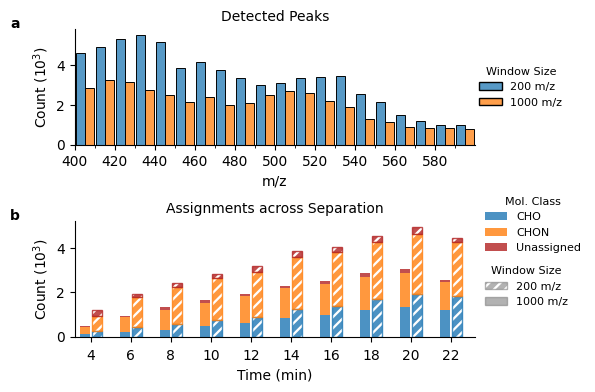

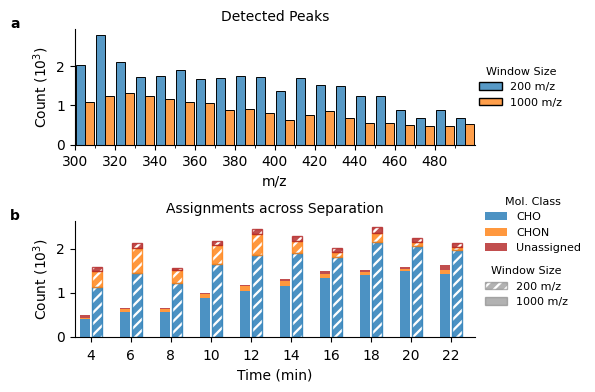

In [87]:
## make figure 1
makeFig1(spring_asgn,dataset_name='spring_env',xlims=[400,600])

makeFig1(wastewater_asgn,dataset_name='wastewater-final-eff',xlims=[300,500])

['CHOCu' 'CHOFe' 'CHOFeCu' 'CHONCu' 'CHONFe' 'CHONFeCu']
['CHOF' 'CHOI' 'CHONF' 'CHONFI' 'CHONI' 'CHONSF' 'CHOSF' 'CHOSI']
['CHOCu' 'CHOFeCu' 'CHONFe' 'CHONFeCu']
['CHOF' 'CHOI' 'CHONF' 'CHONFI' 'CHONI' 'CHONSF' 'CHOSF']
['CHOCu' 'CHOFe' 'CHOFeCu' 'CHONCu' 'CHONFe' 'CHONFeCu']
['CHOF' 'CHOI' 'CHONF' 'CHONFI' 'CHONI' 'CHONSF' 'CHOSF' 'CHOSI']


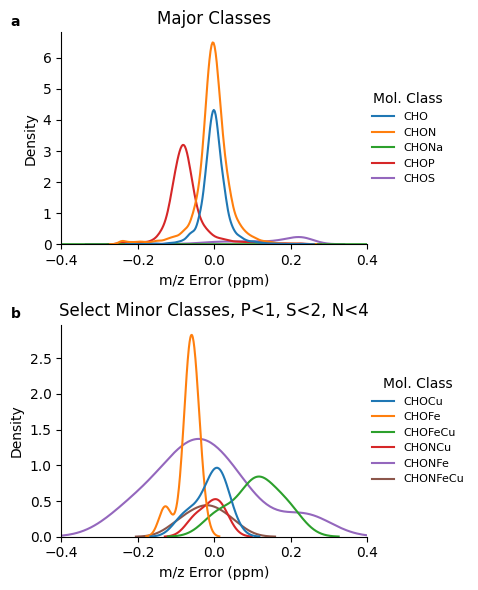

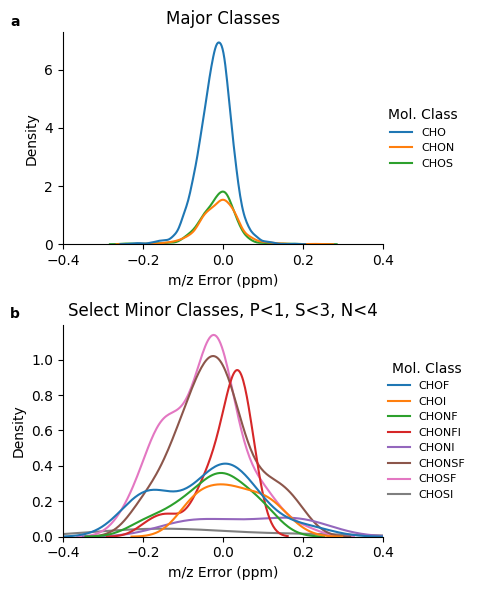

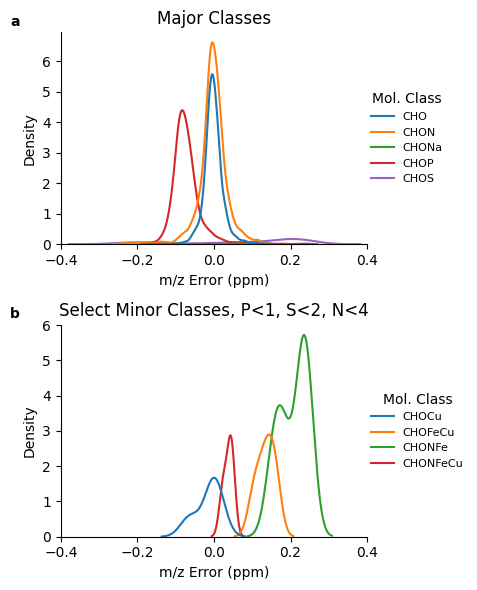

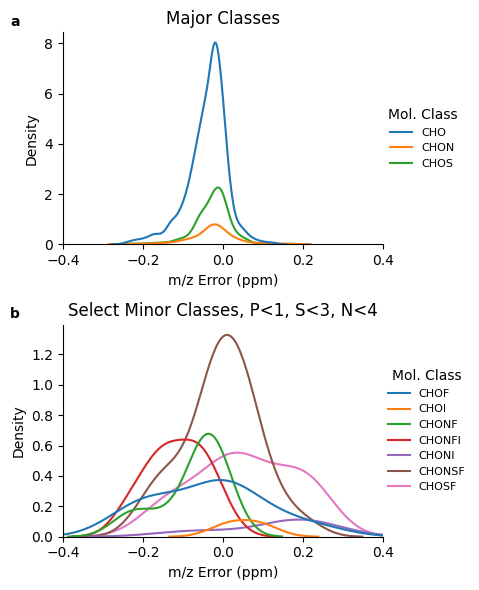

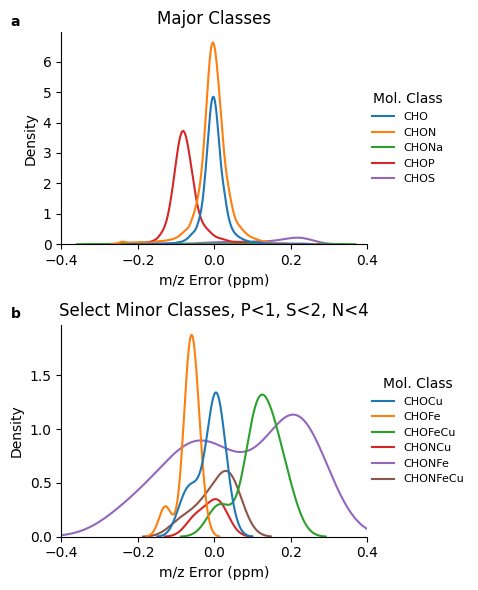

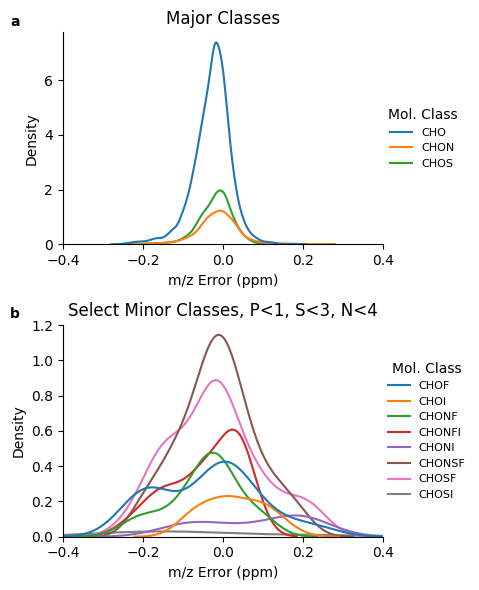

In [8]:
### make KDE error plots
windows = ['narrow', 'full', 'both']
for window in windows:
    plotErrorKde(spring_asgn,dataset_name = 'spring_env', window = window)

    plotErrorKde(wastewater_asgn,dataset_name = 'wastewater-final-eff', window = window)

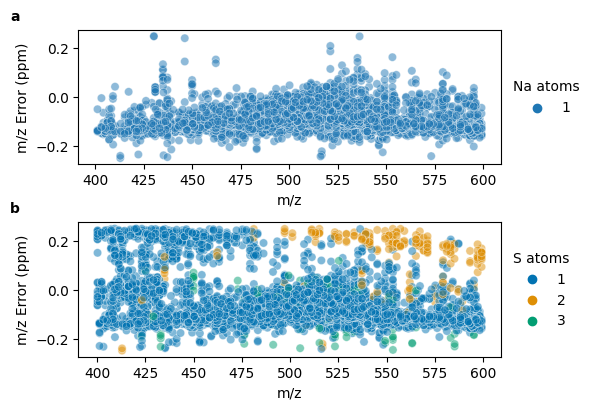

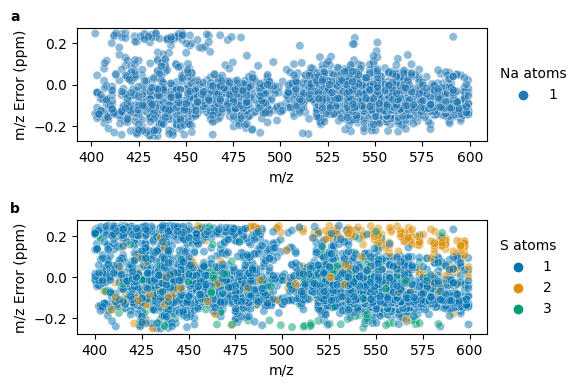

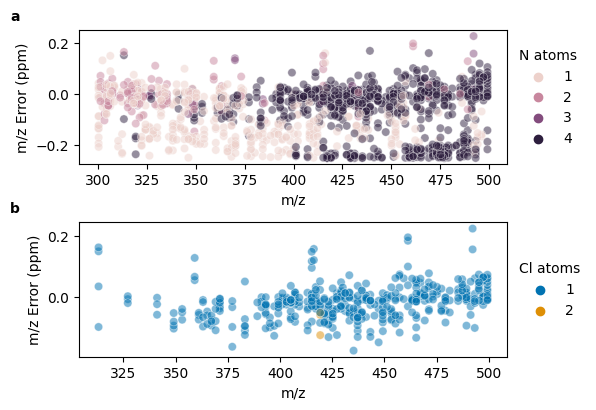

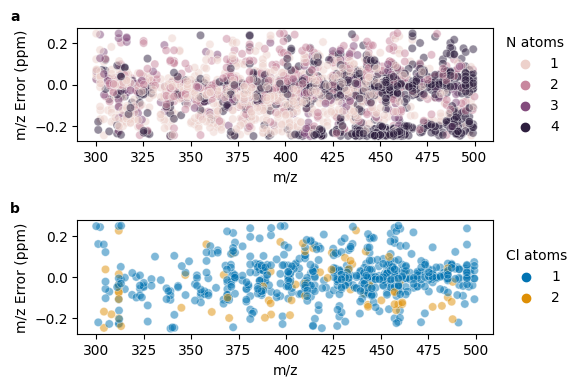

In [48]:
### make mz v. error ppm plots

plotMzVError(spring_asgn, element1='Na', element2='S')

plotMzVError(wastewater_asgn, element1='N', element2='Cl')

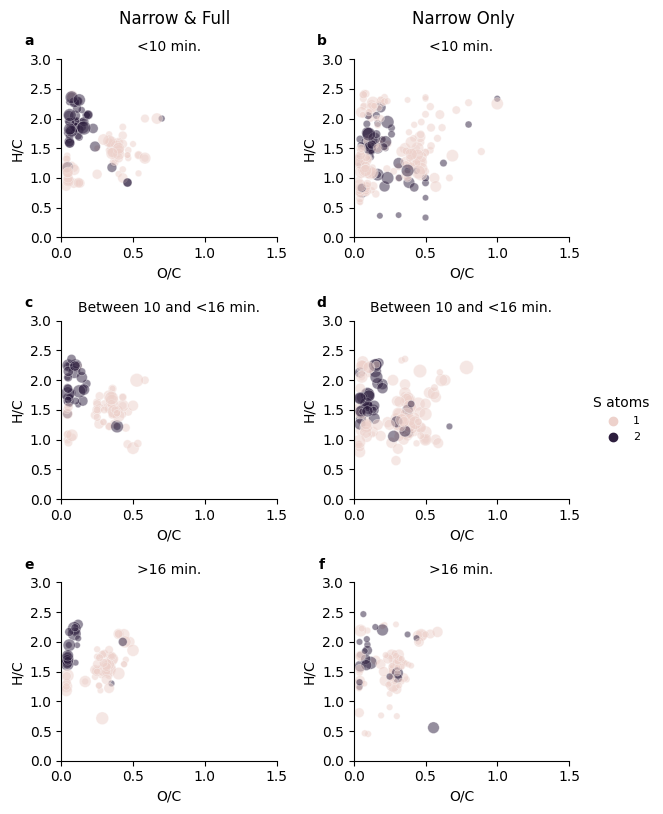

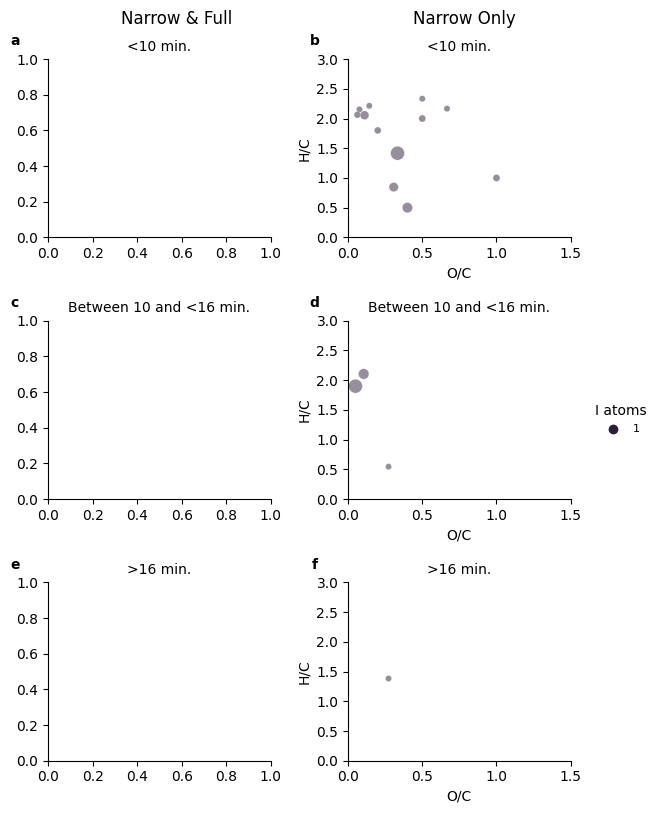

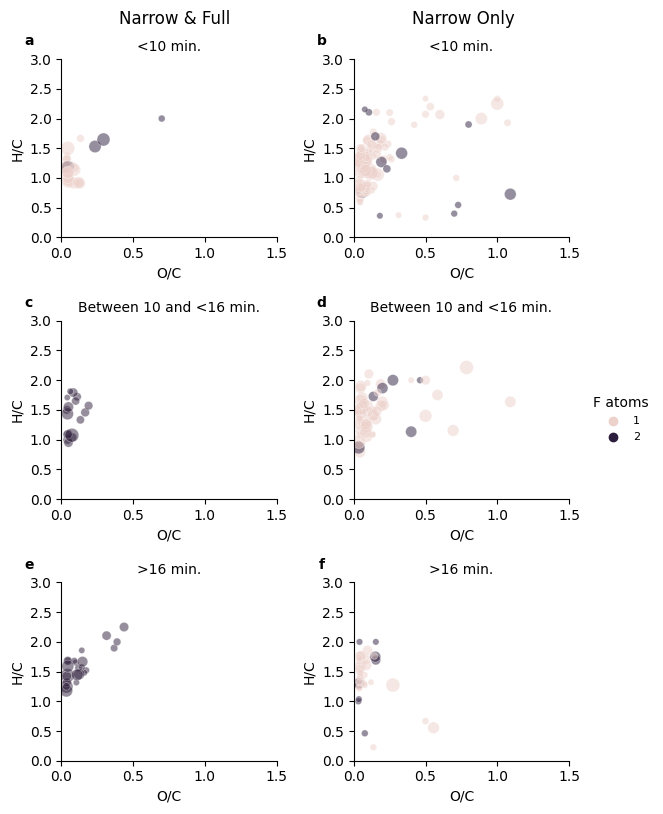

In [210]:
make_S_VKpanels(wastewater_asgn) 
make_I_VKpanels(wastewater_asgn)
make_F_VKpanels(wastewater_asgn)

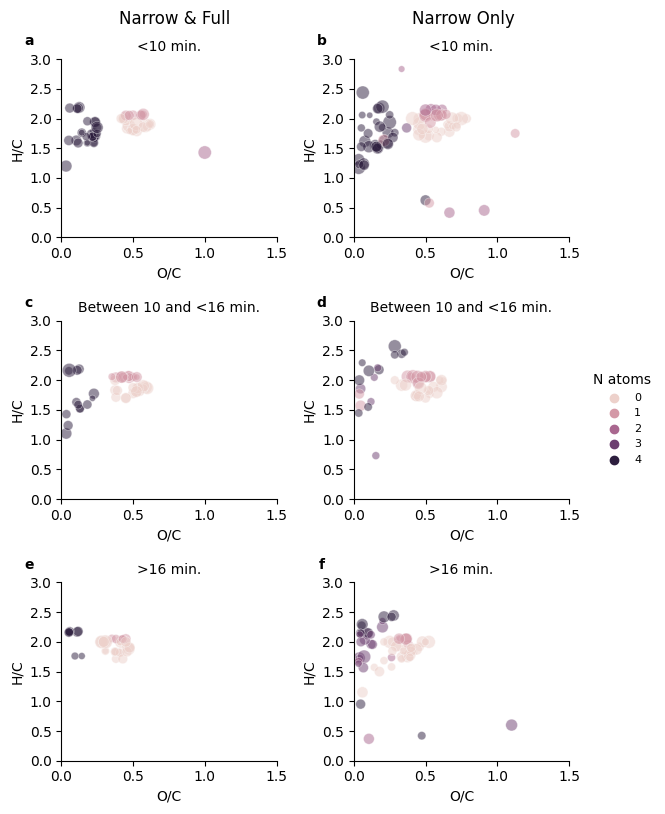

In [211]:
make_Cu_VKpanels(spring_asgn)

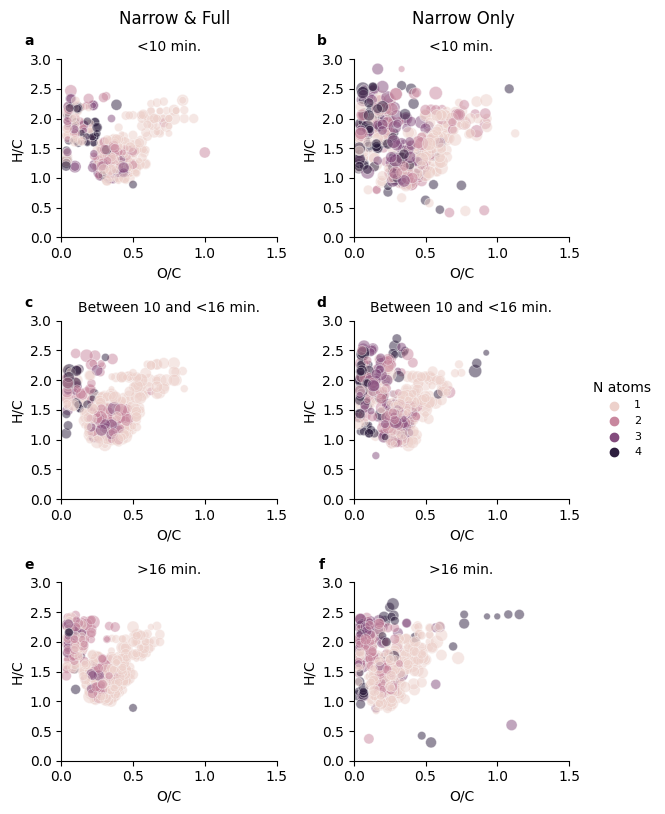

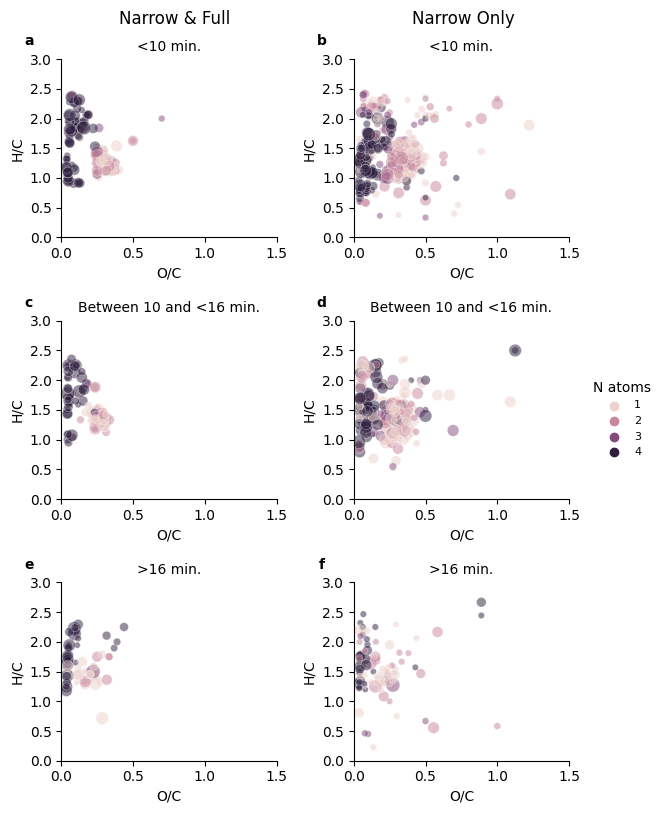

In [212]:
make_N_VKpanels(spring_asgn)
make_N_VKpanels(wastewater_asgn)

NameError: name 'features_in_all' is not defined

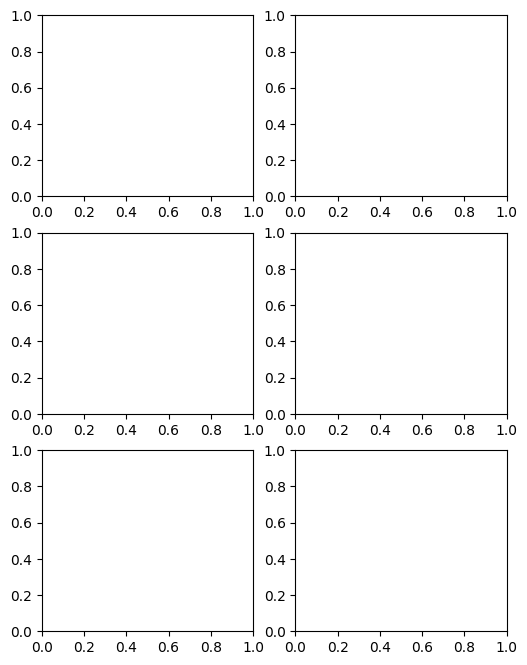

In [49]:
## FIGURES 2&3 van Krevelen plots for (i) features in narrow and full windows and (ii) features not in full window, with N and Fe coloring for different S/N bins

time = 12
time2 = 16
snthresh = 5
snthresh_low = 0
el = 'N'
ttt = 'vanKrevelen_N_0-SN-5.pdf'
fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

feat

df = features_in_all[(features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax,el,'C0')
ax.set_title('Entire separation', size = 10)

df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax2,el,'C0')
ax2.set_title('Retained <%s min.' %time, size = 10)

df = features_in_all[features_in_all['Time']>time2 & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax3,el,'C0')
ax3.set_title('Retained >%s min.' %time2, size = 10)


dfm = features_not_in_full

df = dfm[(dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax4,el,'C1')
ax4.set_title('Entire separation', size = 10)

df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax5,el,'C1')
ax5.set_title('Retained <%s min.' %time, size = 10)

df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax6,el,'C1',leg=True)
ax6.set_title('Retained >%s min.' %time2, size = 10)
h, l = ax6.get_legend_handles_labels()
legend = ax6.legend()
legend.remove()

if el == 'Fe':
    L = fig.legend(h[1:3],l[1:3],title = 'Fe atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')

elif el == 'N':
    L = fig.legend(h[1:6],l[1:6],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')
    L.get_texts()[2].set_text('2')
    L.get_texts()[3].set_text('3')
    L.get_texts()[4].set_text('4')


plt.setp(L.get_title(),fontsize=10)

axs = [ax, ax2, ax3, ax4, ax5, ax6]
lbls = ['a','c','e','b','d','f']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)

fig.tight_layout()
fig.text(0.3, 1.0,'Narrow & Full',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)

fig.text(0.78, 1.0,'Narrow Only',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)


sns.despine()
plt.show()
#plt.savefig(svdir+ttt, bbox_inches = 'tight')

In [ ]:
## FIGURES 4 van Krevelen plots for (i) features in narrow and full windows and (ii) features not in full window, with DBE coloring for different S/N bins

time = 12
time2 = 16
snthresh = 20
snthresh_low = 5
el = 'Confidence Score'
ttt = 'vanKrevelen_Cscore_5-SN-20.pdf'
fig,((ax,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (6,8))

df = features_in_all[(features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax,el,'C0')
ax.set_title('Entire separation', size = 10)

df = features_in_all[(features_in_all['Time']<time) & (features_in_all['S/N']<snthresh) & (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax2,el,'C0')
ax2.set_title('Retained <%s min.' %time, size = 10)

df = features_in_all[features_in_all['Time']>time2 & (features_in_all['S/N']<snthresh)& (features_in_all['S/N']>snthresh_low)]
vanKrevelen(df,ax3,el,'C0')
ax3.set_title('Retained >%s min.' %time2, size = 10)


dfm = features_not_in_full

df = dfm[(dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax4,el,'C1')
ax4.set_title('Entire separation', size = 10)

df = dfm[(dfm['Time']<time) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax5,el,'C1')
ax5.set_title('Retained <%s min.' %time, size = 10)

df = dfm[(dfm['Time']>time2) & (dfm['S/N']<snthresh)& (dfm['S/N']>snthresh_low)]
vanKrevelen(df,ax6,el,'C1',leg=True)
ax6.set_title('Retained >%s min.' %time2, size = 10)
h, l = ax6.get_legend_handles_labels()
legend = ax6.legend()
legend.remove()

'''if el == 'Fe':
    L = fig.legend(h[1:3],l[1:3],title = 'Fe atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')

elif el == 'N':
    L = fig.legend(h[1:6],l[1:6],title = 'N atoms',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')
    L.get_texts()[0].set_text('0')
    L.get_texts()[1].set_text('1')
    L.get_texts()[2].set_text('2')
    L.get_texts()[3].set_text('3')
    L.get_texts()[4].set_text('4')'''

L = fig.legend(h[1:-6],l[1:-6],title = 'Confidence Score',fontsize = 8, frameon = False, bbox_to_anchor = (0.98, 0.5), loc = 'center left')

for i, dbe in zip(range(len(h)-7),l[1:-6]):
    L.get_texts()[i].set_text('%.2f' % float(dbe))

plt.setp(L.get_title(),fontsize=10)

axs = [ax, ax2, ax3, ax4, ax5, ax6]
lbls = ['a','c','e','b','d','f']
for ax, lbl in zip(axs,lbls):
    panelLabel(ax,lbl)

fig.tight_layout()
fig.text(0.3, 1.0,'Narrow & Full',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)

fig.text(0.78, 1.0,'Narrow Only',
    horizontalalignment='center',
    verticalalignment='center', fontsize = 12)


sns.despine()

plt.savefig(svdir+ttt, bbox_inches = 'tight')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

icpms_file = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/spring_env.csv'
icpms = pd.read_csv(icpms_file, sep=';',header=1)


metals = ['63Cu','56Fe']

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Spring (ENV)')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(0,30)
ax.set_ylim(bottom = 0)

x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)
fig.tight_layout()
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

flist = ['slough_env.csv']  #'spring_env.csv',
title = 'DOM-Cu'
#flist = ['spring_ppl.csv','slough_ppl.csv']
#title = 'PPL SPE Column'
labels = ['Slough'] #'Seep', 
alphas = [1,0.5]
labs = {f:l for f,l in zip(flist,labels)}
transp = {f:a for f,a in zip(flist,alphas)}

dir = '/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/Keck iCAP Q/2022/2022-09/Tillamook, Sept 2022/'

metals = ['63Cu']
colors = ['C0', 'C1']
cols = {m:c for m,c in zip(metals,colors)}


fig, ax = plt.subplots()

for me in metals:

    maxicp = 0 

    for f in flist:

        icpms_file = dir + f
        icpms = pd.read_csv(icpms_file, sep=';',header=1)
        mw = me[:2]
        sym = me[2:]
        plab = '$^{%s}$%s' %(mw,sym)
        me_key = 'Time %s' %me
        ax.plot(icpms[me_key]/60, icpms[me], label=plab+', '+labs[f],color = cols[me], alpha = transp[f])        
        

#ax.set_ylim(0,maxicp*1.1)
#ax.set_title(title)
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICP-MS signal (cps)')
#ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper right')

ax.set_xlim(0,30)
ax.set_ylim(bottom = 0, top = 1.25e5)
ax.yaxis.set_major_locator(MultipleLocator(2.5e4))

'''x = np.arange(0.0, 4, 0.01)
ax.fill_between(x, 0,1e6,  color = 'gray',alpha=0.5)
x = np.arange(24, 30, 0.01)
ax.fill_between(x, 0,1e6, color = 'gray', alpha=0.5)'''
current_yvalues = plt.gca().get_yticks()
ylabs = []
for y in current_yvalues:
    if y == 0:
        d = int(0)
    else:
        d = '{:.1f} x $10^5$'.format(y/1e5)
    ylabs.append(d)
#plt.gca().set_yticklabels(['{:.1f} x $10^5$'.format(y/1e5) for y in current_yvalues])
plt.gca().set_yticklabels(ylabs)


fig.tight_layout()
plt.show()

In [ ]:
from tabulate import tabulate
geochem = pd.DataFrame(columns = ['Seep', 'Slough'], index = ['pH', 'Conductivity (mS/cm)','DO (mg/L)','T (C)','Total Cu (uM)', 'Total Fe (uM)', 'DOC (mM)'])

seep = [5.5, 1000,0.1, 8, 100,200,4]
slough = [7.2, 200,8, 8, 50,100,3]

geochem['Seep'] = seep
geochem['Slough'] = slough

geochem

ctest = tabulate(geochem, headers=['Seep', 'Slough'], tablefmt='latex')




In [ ]:
alldf = pd.concat([unique_fullmz_456, unique_200mz])
#alldf = unique_100mz_456

times = data_df['Time'].unique()

holder = {}
summary = []
summary2 = []

for mzw in alldf['m/z Window Size'].unique():
    
    sub1 = alldf[alldf['m/z Window Size'] == mzw]

    for t in times:
        
        print(mzw)
        lsh = {}
        lsh['m/z Window Size'] = mzw

        sub2 = sub1[sub1['Time'] == t]

        sub2 = sub2[sub2['S/N'] > 3]
        
        dynamic_range_t = max(sub2['Peak Height']/min(sub2['Peak Height']))
        
        lsh['Time'] = t
        lsh['Dynamic Range'] = dynamic_range_t        
        lsh['n Features'] = len(sub2)
        lsh['Max I'] = max(sub2['Peak Height'])
        lsh['Min I'] = min(sub2['Peak Height'])
        summary.append(lsh)


df=pd.DataFrame(summary)

sns.boxplot(data=df, x="Dynamic Range", y="m/z Window Size")

In [ ]:

pdf = PdfPages('/Users/christiandewey/Library/CloudStorage/Box-Box/data/assignments/spring/eics_cu_100mz_fullmz-dec13.pdf')

fig, ax = plt.subplots()

maxicp = 0 
for me in metals:
    me_key = 'Time %s' %me
    ax.plot(icpms[me_key]/60, icpms[me], label=me)        
    



#ax.set_ylim(0,maxicp*1.1)
ax.set_title('Cu ICPMS Trace')
ax.set_xlabel('Time (min)')
ax.set_ylabel('ICPMS signal (cps)')
ax.legend(bbox_to_anchor=(1.05,0.5),loc='center left',frameon =False)
ax.set_xlim(2,30)
fig.tight_layout()
pdf.savefig()

for mf in mz100_EICdic:   

    fig, ax = plt.subplots()
    
    eict=mz100_EICdic[mf].time
    eics=mz100_EICdic[mf].eic

    inds = np.where(np.asarray(eict)<28)

    eict = np.asarray(eict)[inds]
    eics = np.asarray(eics)[inds]

    ax.plot(eict, eics,color = 'red', label=r'$\Delta$m/z 100 window')

    if mf in fullmz_EICdic:
        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C0', label = 'full window')
    ax.set_xlim(4,28)
    ax.set_title(mf)
    ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
    fig.tight_layout()
    pdf.savefig()

for mf in fullmz_EICdic:   

    if mf not in mz100_EICdic:

        fig, ax = plt.subplots()

        eic2t = fullmz_EICdic[mf].time
        eic2s = fullmz_EICdic[mf].eic

        inds = np.where(np.asarray(eic2t)<28)

        eic2t = np.asarray(eic2t)[inds]
        eic2s = np.asarray(eic2s)[inds]
        ax.plot(eic2t,eic2s, color ='C5', label = 'full window')

        ax.set_xlim(4,28)
        ax.set_title(mf)
        ax.legend(frameon = False,bbox_to_anchor=(1.05,0.5),loc='center left')
        fig.tight_layout()
        pdf.savefig()

pdf.close()